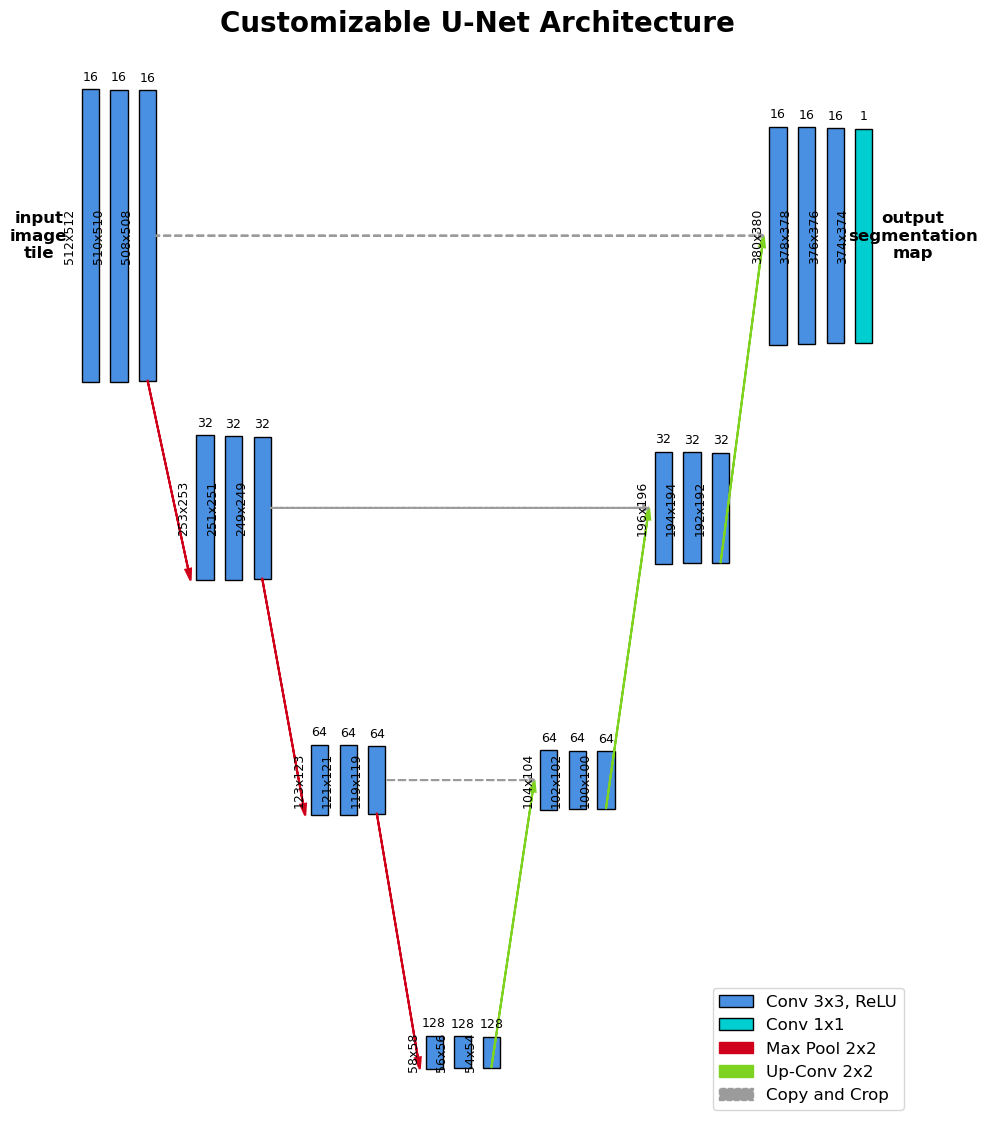

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def draw_unet(
    num_layers=4,
    initial_filters=64,
    conv_depth=2,
    input_size=(572, 572),
    output_channels=2,
    figure_size=(20, 12)
):
    """
    Generates a customizable U-Net architecture diagram with corrected layout.

    Args:
        num_layers (int): Number of downsampling/upsampling stages (depth of the 'U').
        initial_filters (int): Number of filters in the first convolutional block.
        conv_depth (int): Number of convolutional layers in each block.
        input_size (tuple): (height, width) of the input image tile.
        output_channels (int): Number of output channels in the segmentation map.
        figure_size (tuple): (width, height) of the matplotlib figure.
    """
    
    # --- Hardcoded parameters from the U-Net paper ---
    downsample_factor = 2
    upsample_factor = 2
    loss_per_conv = 2  # For 3x3 'valid' padding convolution
    conv_kernel_size = 3
    final_conv_kernel_size = 1

    # --- Colors and Styles ---
    conv_color = '#4a90e2'      # Blue for convolutions
    pool_color = '#d0021b'      # Red for max pooling
    upsample_color = '#7ed321'  # Green for up-sampling
    copy_crop_color = '#9b9b9b' # Gray for skip connections
    final_conv_color = '#00CED1'# Darker cyan for final output

    fig, ax = plt.subplots(figsize=figure_size)
    ax.axis('off')
    ax.set_aspect('equal', adjustable='box')

    # --- Layout parameters ---
    rect_width = 0.6
    rect_height_scale = 0.02
    h_spacing_conv = 1.0 # Horizontal spacing between convs in a block
    h_spacing_layer = 4.0 # Horizontal spacing between layers
    v_spacing_layer = 9.5 # Vertical spacing between layers
    arrow_line_width = 1.5
    arrow_head_width = 0.2

    # --- Data tracking ---
    encoder_block_centers = {} # Store center coords for skip connections
    current_size = np.array(input_size)
    current_filters = initial_filters

    # --- Start Coordinates ---
    x_start, y_start = 1, figure_size[1] / 2
    
    ## -------------------- Encoder Path (Contracting Path) -------------------- ##
    for i in range(num_layers):
        # Calculate base coordinates for the current layer
        x_base = x_start + i * h_spacing_layer
        y_base = y_start - i * v_spacing_layer
        current_x = x_base

        # Draw convolutional block
        for c in range(conv_depth):
            rect = patches.Rectangle(
                (current_x, y_base - (current_size[0] * rect_height_scale / 2)),
                rect_width, current_size[0] * rect_height_scale,
                facecolor=conv_color, edgecolor='black'
            )
            ax.add_patch(rect)
            ax.text(current_x + rect_width / 2, y_base + (current_size[0] * rect_height_scale / 2) + 0.2,
                    f"{current_filters}", ha='center', va='bottom', fontsize=9)
            ax.text(current_x - 0.2, y_base, f"{current_size[0]}x{current_size[1]}",
                    rotation=90, ha='right', va='center', fontsize=9)
            
            current_size -= loss_per_conv
            current_x += h_spacing_conv
        
        # Store the center of the last feature map for the skip connection
        encoder_block_centers[i] = {
            'x': current_x - h_spacing_conv + rect_width,
            'y': y_base,
            'size': current_size
        }

        # Draw max pooling arrow (if not the last layer)
        if i < num_layers:
            ax.arrow(
                current_x - h_spacing_conv + rect_width / 2, y_base - (current_size[0] * rect_height_scale / 2),
                h_spacing_layer/2 - h_spacing_conv/2, -v_spacing_layer + (current_size[0] - current_size[0] / downsample_factor) * rect_height_scale / 2,
                head_width=arrow_head_width, head_length=0.4, fc=pool_color, ec=pool_color, length_includes_head=True, lw=arrow_line_width
            )
            current_size //= downsample_factor
            current_filters *= 2
    
    ## -------------------- Bottleneck -------------------- ##
    x_base = x_start + num_layers * h_spacing_layer
    y_base = y_start - num_layers * v_spacing_layer
    current_x = x_base
    
    for c in range(conv_depth):
        rect = patches.Rectangle(
            (current_x, y_base - (current_size[0] * rect_height_scale / 2)),
            rect_width, current_size[0] * rect_height_scale,
            facecolor=conv_color, edgecolor='black'
        )
        ax.add_patch(rect)
        ax.text(current_x + rect_width / 2, y_base + (current_size[0] * rect_height_scale / 2) + 0.2,
                f"{current_filters}", ha='center', va='bottom', fontsize=9)
        ax.text(current_x - 0.2, y_base, f"{current_size[0]}x{current_size[1]}",
                rotation=90, ha='right', va='center', fontsize=9)
        current_size -= loss_per_conv
        current_x += h_spacing_conv

    ## -------------------- Decoder Path (Expansive Path) -------------------- ##
    for i in range(num_layers - 1, -1, -1):
        # Up-sampling
        current_filters //= 2
        ax.arrow(
            current_x - h_spacing_conv + rect_width / 2, y_base - (current_size[0] * rect_height_scale / 2),
            h_spacing_layer/2 - h_spacing_conv/2, v_spacing_layer - (current_size[0] - current_size[0] * upsample_factor) * rect_height_scale / 2,
            head_width=arrow_head_width, head_length=0.4, fc=upsample_color, ec=upsample_color, length_includes_head=True, lw=arrow_line_width
        )
        current_size *= upsample_factor
        
        # Calculate positions for this decoder level
        x_base = x_start + (num_layers + (num_layers - i)) * h_spacing_layer
        y_base = y_start - i * v_spacing_layer
        current_x = x_base
        
        # Draw skip connection arrow
        encoder_pos = encoder_block_centers[i]
        ax.arrow(
            encoder_pos['x'], encoder_pos['y'],
            x_base - encoder_pos['x'] - 0.2, 0,
            head_width=arrow_head_width, head_length=0.2, fc=copy_crop_color, ec=copy_crop_color,
            length_includes_head=True, lw=arrow_line_width, linestyle='--'
        )
        
        # Draw convolutional block
        for c in range(conv_depth):
            rect = patches.Rectangle(
                (current_x, y_base - (current_size[0] * rect_height_scale / 2)),
                rect_width, current_size[0] * rect_height_scale,
                facecolor=conv_color, edgecolor='black'
            )
            ax.add_patch(rect)
            ax.text(current_x + rect_width / 2, y_base + (current_size[0] * rect_height_scale / 2) + 0.2,
                    f"{current_filters}", ha='center', va='bottom', fontsize=9)
            ax.text(current_x - 0.2, y_base, f"{current_size[0]}x{current_size[1]}",
                    rotation=90, ha='right', va='center', fontsize=9)
            
            current_size -= loss_per_conv
            current_x += h_spacing_conv

    ## -------------------- Final Output Layer -------------------- ##
    rect = patches.Rectangle(
        (current_x, y_base - (current_size[0] * rect_height_scale / 2)),
        rect_width, current_size[0] * rect_height_scale,
        facecolor=final_conv_color, edgecolor='black'
    )
    ax.add_patch(rect)
    ax.text(current_x + rect_width / 2, y_base + (current_size[0] * rect_height_scale / 2) + 0.2,
            f"{output_channels}", ha='center', va='bottom', fontsize=9)
    ax.text(current_x - 0.2, y_base, f"{current_size[0]}x{current_size[1]}",
            rotation=90, ha='right', va='center', fontsize=9)

    # --- Add input and output labels ---
    ax.text(x_start-1.5, y_start, "input\nimage\ntile", ha='center', va='center', fontsize=12, weight='bold')
    ax.text(current_x+2, y_start, "output\nsegmentation\nmap", ha='center', va='center', fontsize=12, weight='bold')

    ## -------------------- Legend -------------------- ##
    legend_elements = [
        patches.Patch(facecolor=conv_color, edgecolor='black', label=f'Conv {conv_kernel_size}x{conv_kernel_size}, ReLU'),
        patches.Patch(facecolor=final_conv_color, edgecolor='black', label=f'Conv {final_conv_kernel_size}x{final_conv_kernel_size}'),
        patches.Patch(color=pool_color, label=f'Max Pool {downsample_factor}x{downsample_factor}'),
        patches.Patch(color=upsample_color, label=f'Up-Conv {upsample_factor}x{upsample_factor}'),
        patches.Patch(color=copy_crop_color, linestyle='--', label='Copy and Crop')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=12)

    plt.title("Customizable U-Net Architecture", fontsize=20, weight='bold')
    plt.show()

# --- Example Usage (matches the original U-Net paper) ---
draw_unet(
    num_layers=3,
    initial_filters=16,
    conv_depth=3,
    input_size=(512, 512),
    output_channels=1,
    figure_size=(24, 14)
)